# Test Functional Coherence of GO Terms in Clusters

In [47]:
# @title Download and Install PHILHARMONIC

try:
    import importlib.util

    importlib.util.find_spec("google.colab")

    IN_COLAB = True
except ModuleNotFoundError:
    IN_COLAB = False

if IN_COLAB:
    !git clone https://github.com/samsledje/philharmonic.git
    !cd philharmonic; pip install -e .
    !curl https://current.geneontology.org/ontology/go.obo -o go.obo
    !curl https://current.geneontology.org/ontology/subsets/goslim_generic.obo -o goslim_generic.obo

from itertools import combinations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from loguru import logger
from scipy.spatial.distance import jaccard
from scipy.stats import ttest_ind
from tqdm import tqdm

from philharmonic.utils import (
    add_GO_function,
    load_cluster_json,
    parse_GO_database,
    parse_GO_map,
)

In [48]:
# @title Loading PHILHARMONIC results
# @markdown Upload your zipped results file using the "Files" tab to the left.
# @markdown Set the `RUN_NAME` variable to the name of the run from your config file you want to analyze.
# @markdown If you are running this locally, edit the `RESULTS_DIR` variable to point to your results directory, and point to a locally downloaded go.obo file.

ZIP_FILE_NAME = ""  # @param {"type":"string","placeholder":"philharmonic_results.zip"}
RUN_NAME = "20240917-pdamAll-phil_v0.3.0"  # @param {"type":"string","placeholder":"philharmonic_run"}
# RUN_NAME = "20240926_cgoreaui"
# RUN_NAME = "20240912-dmelaAll-phil_v0.2.0"
RESULTS_DIR = "."  # @param {"type":"string","placeholder":"."}
USE_GO_SLIM = False  # @param {"type":"boolean"}

if IN_COLAB:
    !unzip $ZIP_FILE_NAME
    results_dir = Path(".")
    GO_OBO_PATH = "go.obo"
    GO_SLIM_PATH = "goslim_generic.obo"
else:
    RESULTS_DIR = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/p_damicornis/20240917-pdamAll-phil_v0.3.0"
    # RESULTS_DIR = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/c_goreaui/20240926_philharmonic_v0.5.0_cgoreaui"
    # RESULTS_DIR = "/mnt/home/ssledzieski/Projects/philharmonic-experiments/results/d_melanogaster/20240913-dmelaAll-phil_v0.2.0"
    results_dir = Path(RESULTS_DIR)
    GO_OBO_PATH = results_dir / "go.obo"
    GO_SLIM_PATH = results_dir / "goslim_generic.obo"

CLUSTER_FILE_PATH = results_dir / f"{RUN_NAME}_clusters.json"
CLUSTER_FUNC_PATH = results_dir / f"{RUN_NAME}_cluster_graph_functions.tsv"
GO_MAP_PATH = results_dir / f"{RUN_NAME}_GO_map.csv"
IMG_DIR = results_dir / "img"
!mkdir -p $IMG_DIR

clusters = load_cluster_json(CLUSTER_FILE_PATH)
go_map = parse_GO_map(GO_MAP_PATH)

if USE_GO_SLIM:
    go_db = parse_GO_database(GO_SLIM_PATH)
else:
    go_db = parse_GO_database(GO_OBO_PATH)

for clust in clusters.values():
    clust["GO_terms"] = add_GO_function(clust, go_map, go_db=go_db)
    for gt in clust["GO_terms"].keys():
        assert gt in go_db.keys()

---

## Native Cluster Coherence

In [49]:
go_assigned = set()
for clust in tqdm(clusters.values()):
    for m in clust["members"]:
        go_assigned.update(go_map.get(m, []))
go_assigned = sorted(list(go_assigned.intersection(go_db.keys())))

logger.info(f"{len(go_assigned)} GO terms assigned")

100%|██████████| 468/468 [00:00<00:00, 10204.48it/s]
2024-10-22 11:18:40.344 | INFO     | __main__:<module>:7 - 10799 GO terms assigned


In [50]:
proteins_in_clusters = []
for clust in tqdm(clusters.values()):
    proteins_in_clusters.extend(clust["members"])
    proteins_in_clusters.extend(list(clust["recipe"]["degree"]["0.75"]))
logger.info(f"{len(proteins_in_clusters)} proteins in clusters")

100%|██████████| 468/468 [00:00<00:00, 453019.68it/s]
2024-10-22 11:18:40.356 | INFO     | __main__:<module>:5 - 12083 proteins in clusters


In [51]:
def protein_GO_bit_vector(
    protein_id, go_map, full_go_list, id_col="seq", go_col="GO_ids"
):
    go_bv = np.zeros(len(full_go_list))
    prot_go = go_map.get(protein_id)
    if prot_go is not None:
        for gid in prot_go:
            if gid in full_go_list:
                go_bv[full_go_list.index(gid)] = 1
    return go_bv


# Compute GO bit vectors for each protein
protein_GO_bvs = {}
for pid in tqdm(proteins_in_clusters):
    protein_GO_bvs[pid] = protein_GO_bit_vector(pid, go_map, go_assigned)

  0%|          | 0/12083 [00:00<?, ?it/s]

100%|██████████| 12083/12083 [01:30<00:00, 134.00it/s]


In [52]:
cluster_jaccards = {}

for k, clust in tqdm(clusters.items()):
    cjaccard = []
    for p1, p2 in combinations(
        clust["members"] + list(clust["recipe"]["degree"]["0.75"]), 2
    ):
        jc = 1 - jaccard(protein_GO_bvs[p1], protein_GO_bvs[p2])
        cjaccard.append(jc)
    cluster_jaccards[k] = np.array(cjaccard)

100%|██████████| 468/468 [00:03<00:00, 122.45it/s]


---

## Shuffled Cluster Coherence

In [53]:
rng = np.random.default_rng(seed=42)
shuffled_bit_vectors = {
    k: v
    for k, v in zip(
        protein_GO_bvs.keys(), rng.permutation(list(protein_GO_bvs.values()))
    )
}

In [54]:
cluster_jaccards_perm = {}

for k, clust in tqdm(clusters.items()):
    cjaccard = []
    for p1, p2 in combinations(
        clust["members"] + list(clust["recipe"]["degree"]["0.75"]), 2
    ):
        jc = 1 - jaccard(shuffled_bit_vectors[p1], shuffled_bit_vectors[p2])
        cjaccard.append(jc)
    cluster_jaccards_perm[k] = np.array(cjaccard)

100%|██████████| 468/468 [00:03<00:00, 121.89it/s]


--- 


## Compare shuffled and original coherence

In [55]:
phil_mean = [np.mean(i) for i in cluster_jaccards.values()]
permute_mean = [np.mean(i) for i in cluster_jaccards_perm.values()]
coherence_df = (
    pd.DataFrame(
        {
            "cluster": list(cluster_jaccards.keys()),
            "PHILHARMONIC": phil_mean,
            "Random Clustering": permute_mean,
        }
    )
    .melt("cluster")
    .rename(
        {"variable": "Clustering Method", "value": "Mean Jaccard Similarity"}, axis=1
    )
)
coherence_df.head()

,cluster,Clustering Method,Mean Jaccard Similarity
0,1820850722272676818,PHILHARMONIC,0.058390
1,1258033634750426039,PHILHARMONIC,0.073552
2,595187191250287510,PHILHARMONIC,0.020665
3,1953122705995928721,PHILHARMONIC,0.189681
4,871092547245650990,PHILHARMONIC,0.012595


In [56]:
from scipy import interpolate


def find_histogram_intersection(data1, data2, bins=50, return_curves=False):
    """
    Find the intersection point of two histograms.

    Parameters:
    data1: array-like, first dataset
    data2: array-like, second dataset
    bins: int, number of bins for histogram
    return_curves: bool, whether to return the interpolated curves

    Returns:
    float: x-value where histograms intersect
    """
    # Create histograms
    hist1, bin_edges = np.histogram(data1, bins=bins, density=True)
    hist2, _ = np.histogram(data2, bins=bin_edges, density=True)

    # Get bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

    # Create interpolation functions
    f1 = interpolate.interp1d(
        bin_centers, hist1, kind="linear", fill_value="extrapolate"
    )
    f2 = interpolate.interp1d(
        bin_centers, hist2, kind="linear", fill_value="extrapolate"
    )

    # Find intersection points
    x_range = np.linspace(bin_centers[0], bin_centers[-1], 1000)
    y1 = f1(x_range)
    y2 = f2(x_range)

    # Find where the difference changes sign
    diff = y1 - y2
    intersection_indices = np.where(np.diff(np.signbit(diff)))[0]

    if len(intersection_indices) == 0:
        raise ValueError("No intersection found")

    # Get x values at intersections
    intersection_points = x_range[intersection_indices]

    if return_curves:
        return max(intersection_points), f1, f2, x_range

    return max(intersection_points)

2024-10-22 11:20:18.692 | INFO     | __main__:<module>:48 - Distributions cross at 0.047


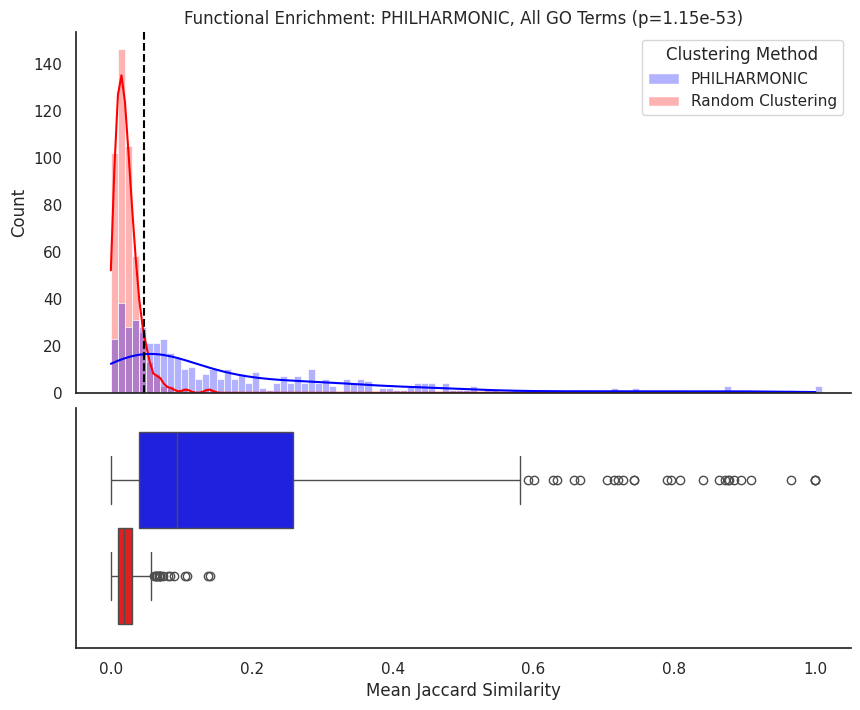

In [57]:
sns.set_palette("colorblind")
sns.set_theme(style="white", palette="pastel", font_scale=1)

# Create figure and gridspec
fig = plt.figure(figsize=(10, 8))
gs = fig.add_gridspec(2, 1, height_ratios=[3, 2], hspace=0.05)

# Create top subplot for histogram
ax0 = fig.add_subplot(gs[0])
ax1 = fig.add_subplot(gs[1])

sns.histplot(
    data=coherence_df,
    x="Mean Jaccard Similarity",
    hue="Clustering Method",
    alpha=0.3,
    bins=np.arange(0, 1.05, 0.01),
    kde=True,
    palette=["blue", "red"],
    common_norm=False,
    ec="white",
    ax=ax0,
)

sns.boxplot(
    data=coherence_df,
    x="Mean Jaccard Similarity",
    hue="Clustering Method",
    palette=["blue", "red"],
    ax=ax1,
)

ax0.set_xlabel("")  # Remove x-label from top plot
ax0.set_xticklabels([])  # Remove x-ticks from top plot

ax0.set_xlim(ax1.get_xlim())  # Align the x-axis of both subplots
ax1.get_legend().remove()  # Remove legend from bottom plot

tstat, p = ttest_ind(phil_mean, permute_mean, alternative="greater")
go_type = "GO Slim" if USE_GO_SLIM else "All GO Terms"
ax0.set_title(f"Functional Enrichment: PHILHARMONIC, {go_type} (p={p:.3})")

intersection_x = find_histogram_intersection(phil_mean, permute_mean, bins=50)
logger.info(f"Distributions cross at {intersection_x:.3f}")
ax0.axvline(intersection_x, linestyle="--", color="black")

# Show the plot
sns.despine()
finame = (
    f"{RUN_NAME}_function_enrichment_GOfull.svg"
    if not USE_GO_SLIM
    else f"{RUN_NAME}_function_enrichment_GOslim.svg"
)
plt.savefig(IMG_DIR / finame, bbox_inches="tight", dpi=300)
plt.show()

---
## Display Coherence by GO Slim Function

In [58]:
cluster_top_terms = pd.read_csv(CLUSTER_FUNC_PATH, sep="\t").set_index("key")

clens = [len(clust["members"]) for clust in clusters.values()]
clen_bin = pd.cut(clens, bins=[0, 5, 10, 15, 20, 25, 30])
cjacc = [np.mean(cluster_jaccards[k]) for k in clusters]
cfunc = [cluster_top_terms.loc[int(k), "go_fn"] for k in clusters]
func_df = pd.DataFrame(
    {
        "Function": cfunc,
        "Mean Jaccard Similarity": cjacc,
        "Cluster Size": clens,
    }
)
func_df["Function"] = func_df["Function"].str.lower()
func_df = func_df.sort_values("Function")
func_df["Function"].fillna("No dominant function", inplace=True)

logger.info(f"Function dataframe shape: {func_df.shape}")

/tmp/ipykernel_3771570/1799512940.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  func_df["Function"].fillna("No dominant function", inplace=True)
2024-10-22 11:20:19.026 | INFO     | __main__:<module>:18 - Function dataframe shape: (468, 3)


In [59]:
import xml.etree.ElementTree as ET

# Define the path to the XML file
xml_file_path = "../assets/philharmonic_styles.xml"

# Parse the XML file
tree = ET.parse(xml_file_path)
root = tree.getroot()

# Extract colors from the "philharmonic" style
philharmonic_colors = {}
for style in root.findall(".//discreteMappingEntry"):
    name = style.get("attributeValue").lower()
    value = style.get("value")
    philharmonic_colors[name] = value

for f in func_df["Function"].unique():
    if f not in philharmonic_colors.keys():
        philharmonic_colors[f] = "#aaaaaa"

In [60]:
grouped_order = (
    func_df.loc[:, ["Function", "Mean Jaccard Similarity"]]
    .groupby(["Function"])
    .median()
    .sort_values(by="Mean Jaccard Similarity")
)

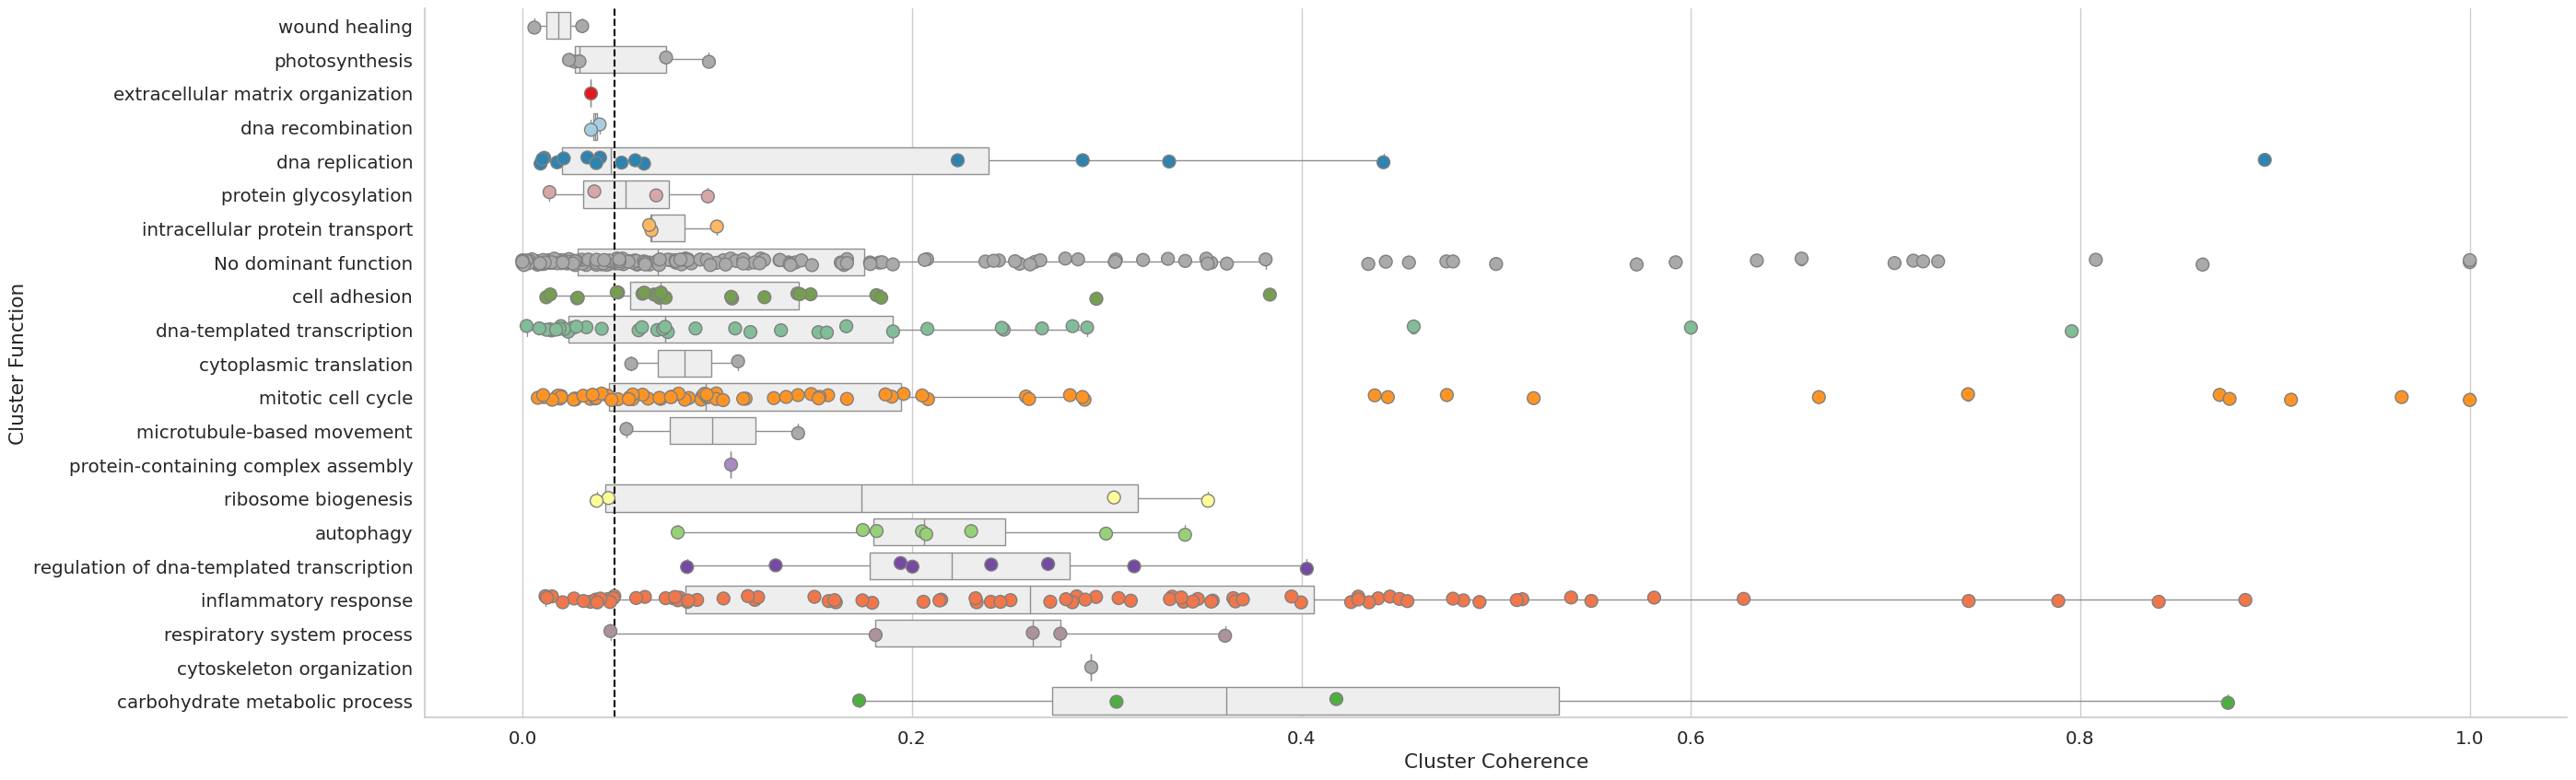

In [61]:
sns.set_theme(style="whitegrid", font_scale=1.3)
fig, ax = plt.subplots(figsize=(30, 10))

sns.stripplot(
    data=func_df,
    x="Mean Jaccard Similarity",
    y="Function",
    ax=ax,
    hue="Function",
    palette=philharmonic_colors,
    order=grouped_order.index,
    s=10,
    edgecolor="grey",
    linewidth=1,
)
sns.boxplot(
    data=func_df,
    x="Mean Jaccard Similarity",
    y="Function",
    ax=ax,
    hue="Function",
    palette={k: "#eeeeee" for k in func_df["Function"].unique()},
    order=grouped_order.index,
)
plt.xlabel("Cluster Coherence")
plt.ylabel("Cluster Function")

ax.axvline(intersection_x, linestyle="--", color="black")

sns.despine()
finame = (
    f"{RUN_NAME}_enrichment_by_function_swarmbox_GOfull.svg"
    if not USE_GO_SLIM
    else f"{RUN_NAME}_by_function_swarmbox_GOslim.svg"
)
plt.savefig(IMG_DIR / finame, bbox_inches="tight", dpi=300)
plt.show()